## Preprocessing

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.optim as optim
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import copy
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.image as mpimg

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!git clone 'https://github.com/Horea94/Fruit-Images-Dataset.git'

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 34.31 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Checking out files: 100% (90503/90503), done.


In [ ]:
dir = '/content/Fruit-Images-Dataset/Training'
for folder in os.listdir(dir):
  folder_path = os.path.join(dir, folder)
  for idx, image in enumerate(os.listdir(folder_path)):
    image_path = os.path.join(folder_path, image)
    if (idx+1) < 10:
      os.rename(image_path, folder_path + '/' + folder + '_00' + str(idx+1) + '.jpg')
    elif (idx+1) < 100:
      os.rename(image_path, folder_path + '/' + folder + '_0' + str(idx+1) + '.jpg')
    else:
      os.rename(image_path, folder_path + '/' + folder + '_' + str(idx+1) + '.jpg')
print('Done.')

Done.


In [ ]:
dir = '/content/Fruit-Images-Dataset/Test'
for folder in os.listdir(dir):
  folder_path = os.path.join(dir, folder)
  for idx, image in enumerate(os.listdir(folder_path)):
    image_path = os.path.join(folder_path, image)
    if (idx+1) < 10:
      os.rename(image_path, folder_path + '/' + folder + '_00' + str(idx+1) + '.jpg')
    elif (idx+1) < 100:
      os.rename(image_path, folder_path + '/' + folder + '_0' + str(idx+1) + '.jpg')
    else:
      os.rename(image_path, folder_path + '/' + folder + '_' + str(idx+1) + '.jpg')
print('Done.')

Done.


In [ ]:
i=0
headerlist = ['image_name', 'target']
with open('./fruit_train.csv', 'w') as f:
  f.write(headerlist[0] + ',' + headerlist[1] + '\n')
  for folder in os.listdir(dir):
    folder_path = os.path.join(dir, folder)
    for image in os.listdir(folder_path):
      f.write(image + ',' + str(i) + '\n')
    i+=1
print('Done.')

Done.


In [ ]:
i=0
dir = '/content/Fruit-Images-Dataset/Test'
headerlist = ['image_name', 'target']
with open('./fruit_test.csv', 'w') as f:
  f.write(headerlist[0] + ',' + headerlist[1] + '\n')
  for folder in os.listdir(dir):
    folder_path = os.path.join(dir, folder)
    for image in os.listdir(folder_path):
      f.write(image + ',' + str(i) + '\n')
    i+=1
print('Done.')

Done.


## Helper function

In [ ]:
class FruitsDataset(Dataset):

  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_name = self.annotations.iloc[index, 0]  # Cherry Rainier_084.jpg
    temp = img_name.split('.')                  # ['Cherry Rainier_084', 'jpg']
    img_name_with_class = temp[0]               # Cherry Rainier_084
    class_name = img_name_with_class[:-4]       # Cherry Rainier
    path = os.path.join(self.root_dir, class_name)
    img_path = os.path.join(path, img_name)
    img = Image.open(img_path).convert('RGB')
    label = torch.tensor(self.annotations.iloc[index, 1])

    if self.transform:
      img = self.transform(img)

    return (img, label)

In [ ]:
dir = '/content/Fruit-Images-Dataset/Training'
i=0
fruit_names = {}
for folder in os.listdir(dir):
  fruit_names[i] = folder
  i+=1
print(fruit_names)

In [ ]:
def visualize_cost (loss_train, acc_train, loss_val, acc_val, num_epochs,
                    loss_train2, acc_train2, loss_val2, acc_val2):
    # plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,7))
    plt.grid()
    plt.subplot(1,2,1)

    split = len(loss_train)
    plt.plot(range(1, split+1), np.array(loss_train), '-o', label='train', linewidth=2, color='b')
    plt.plot(range(split, num_epochs+1), np.array(loss_train2), '-o', linewidth=2, color='b')
    plt.plot(range(1, split+1), np.array(loss_val), '-o', label='val', linewidth=2, color='r')
    plt.plot(range(split, num_epochs+1), np.array(loss_val2), '-o', linewidth=2, color='r')
    plt.axvline(x=5, color='y',label = 'unfreeze')
    plt.xlabel('$Epochs$', size=20)
    plt.ylabel('$Loss$', size=20)
    plt.legend(loc='best', fontsize=20)
    
    plot2 = plt.subplot(1,2,2)
    plot2.plot(range(1, split+1), np.array(acc_train), '-o', label='train', linewidth=2, color='b')
    plot2.plot(range(split, num_epochs+1), np.array(acc_train2), '-o', linewidth=2, color='b')
    plot2.plot(range(1, split+1), np.array(acc_val), '-o', label='val', linewidth=2, color='r')
    plot2.plot(range(split, num_epochs+1), np.array(acc_val2), '-o',linewidth=2, color='r')
    plt.axvline(x=5, color='y',label = 'unfreeze')
    plot2.set_xlabel('$Epochs$', size=20)
    plot2.set_ylabel('$Acc$', size=20)
    plot2.legend(loc='best', fontsize=20)
    plot2.grid(True)

    plt.show()

In [ ]:
def visualize_cost2 (loss_train, acc_train, loss_val, acc_val, num_epochs):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,7))
    plt.grid()
    plt.subplot(1,2,1)

    plt.plot(range(1, num_epochs+1), np.array(loss_train), '-o', label='train', linewidth=2)
    plt.plot(range(1, num_epochs+1), np.array(loss_val), '-o', label='val', linewidth=2)

    plt.axvline(x=5, color='y',label = 'unfreeze net')
    plt.xlabel('$Epochs$', size=20)
    plt.ylabel('$Loss$', size=20)
    plt.legend(loc='best', fontsize=20)
    
    plot2 = plt.subplot(1,2,2)
    plot2.plot(range(1, num_epochs+1), np.array(acc_train), '-o', label='train', linewidth=2)
    plot2.plot(range(1, num_epochs+1), np.array(acc_val), '-o', label='val', linewidth=2)
    plt.axvline(x=5, color='y',label = 'unfreeze net')
    plot2.set_xlabel('$Epochs$', size=20)
    plot2.set_ylabel('$Acc$', size=20)
    plot2.legend(loc='best', fontsize=20)
    plot2.grid(True)

    plt.show()

In [ ]:
def save_checkpoint(state, is_best, filename='check_point.pth'):
  root_dir = '/content/drive/MyDrive/saved_ckpt'
  if is_best:
    print('==> Saving new best')
    torch.save(state, os.path.join(root_dir, filename))
  else:
    print('==> Validation accuracy did not improve.')

In [ ]:
def get_predictions(loader, model):

  model.eval()

  predicted_class = np.array([])
  targets = np.array([])

  with torch.no_grad():
    for idx, (images, labels) in enumerate(loader):

      labelsnp = labels.cpu().numpy()
      targets = np.concatenate((targets, labelsnp), axis=None)

      images = images.to(device) # torch.Size([3, 3, 224, 224]) train_dataset
      labels = labels.to(device) # torch.Size([3])

      y_predicted = model(images) # torch.Size([3, 5])
      _, index = torch.max(y_predicted, 1)

      convert = index.cpu().numpy()
      predicted_class = np.concatenate((predicted_class, convert), axis=None)

  return targets, predicted_class

In [ ]:
def visualize_model(labels_map, num_rows, num_cols, dataset, mean, std, predicted_class):

  plt.figure(figsize=(10, 10))

  for i in range(num_rows*num_cols):
    plt.subplot(num_rows, num_cols, i+1)
    index = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[index]
    image = image.cpu().numpy().transpose(1,2,0)
    image = image * np.array(std) + np.array(mean)
    # image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label.item() == predicted_class[index]:
      check = 'green'
    else: check = 'red'
    plt.title(f'Pred: {labels_map[predicted_class[index]]}', color='white',
              backgroundcolor=check, fontsize=15)

  plt.show()

In [ ]:
def check_accuracy(loader, loader_dataset, model, labels_map):

  if loader == val_loader:
    print('Val Acc')
  elif loader == train_loader:
    print('Train Acc')
  else:
    print('Test Acc')

  running_corrects = 0
  num_samples = 0

  num_classes = len(list(labels_map.values()))

  n_correct_class = [0 for i in range(num_classes)]
  n_class_samples = [0 for i in range(num_classes)]

  model.eval()

  with torch.no_grad():

    for images, labels in loader:

      images = images.to(device)
      labels = labels.to(device)

      y_predicted = model(images)
      _, index = torch.max(y_predicted, 1)

      running_corrects += (index == labels.data).sum()

      temp_ = index.cpu().numpy()
      num_samples += temp_.shape[0]

      temp = labels.cpu().numpy()

      for i in range(temp.shape[0]):
        
        label = temp[i]
        index_i = temp_[i]

        if label == index_i:
          n_correct_class[label] += 1
        n_class_samples[label] += 1

    convert = running_corrects.double()
    acc = convert / len(loader_dataset)
    print(f'Got {int(convert.item())}/{num_samples} correct samples over {acc.item() * 100:.2f}%')

    for i in range(num_classes):
      if n_class_samples[i] != 0:
        acc_ = 100 * n_correct_class[i] / n_class_samples[i]
        print(f'Accuracy of {labels_map[i]}: {acc_:.2f}%')
      else:
        print(f'Class {labels_map[i]} does not have its sample in this dataset.')

In [ ]:
def predict(model, image_path, transform, labels_map, mean, std):

  image = Image.open(image_path).convert('RGB')
  image = transform(image)
  image = image.unsqueeze(0)
  image = image.to('cuda')

  model.eval()
  with torch.no_grad():

    y_predicted = model(image)
    _, index = torch.max(y_predicted, 1)

  pred = index.cpu().numpy()
  predicted_class = int(pred[0])

  img = mpimg.imread(image_path)
  plt.imshow(img)

  plt.title(f'Predicted: {labels_map[predicted_class]}', size=20)
  plt.axis('off')
  plt.show()

def predict_single(model, image_path):
  predict(model, image_path, test_trans, fruit_names, mean, std)

## Preparation

In [ ]:
mean = torch.tensor([0.6840, 0.5786, 0.5037]) 
std = torch.tensor([0.3035, 0.3600, 0.3914])

train_trans = transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  transforms.RandomRotation(degrees=(0, 360)),
                                  transforms.RandomPerspective(distortion_scale=0.5),
                                  transforms.RandomAffine(degrees=(30, 70)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
])

val_trans = transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  transforms.RandomRotation(degrees=(0, 360)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
])

test_trans = transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  # transforms.RandomRotation(degrees=(0, 360)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)
])

In [ ]:
csv_file = '/content/drive/MyDrive/fruit_train.csv'
dataset = FruitsDataset(csv_file=csv_file, root_dir=dir, transform=train_trans)
print(len(dataset))

67692


In [ ]:
train_len = int(len(dataset)*0.7)
val_len = int(len(dataset) - train_len)
train_dataset, val_dataset = torch.utils.data.random_split(dataset=dataset, lengths=[train_len, val_len])
print(len(train_dataset), len(val_dataset))

47384 20308


In [ ]:
# Hyperparameter
num_epochs = 8
begin_epoch = 0
batch_size = 128
learning_rate = 0.01
load_model = True
load_model_file = '/content/drive/MyDrive/saved_ckpt/ckpt_epch5_acc0.94322.pth'
num_classes = 131

In [ ]:
if load_model:
  loaded = torch.load(load_model_file)
  begin_epoch = loaded['epoch']
  best_acc = loaded['best_val_acc']
  print(f'Training resumes at epoch {begin_epoch}')
  print(f'Last best validation accuracy is {best_acc}')

Training resumes at epoch 5
Last best validation accuracy is 0.943224310874939


In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

## Load model

In [ ]:
model = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
  param.requires_grad = True

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
if load_model:
  loaded = torch.load(load_model_file)
  model.load_state_dict(loaded['model'])
  optimizer.load_state_dict(loaded['optimizer'])

In [ ]:
model = model.to(device)

## Training

In [ ]:
# writer_train = SummaryWriter(f'/content/drive/MyDrive/training_fruits/training/train')
# writer_val = SummaryWriter(f'/content/drive/MyDrive/training_fruits/training/val')

In [ ]:
n_iters1 = math.ceil(len(train_dataset) / batch_size)
n_iters2 = math.ceil(len(val_dataset) / batch_size)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
start = time.time()

# step = 0
# step2 = 0

if load_model:
  loaded = torch.load(load_model_file)
  loss_cache_train = loaded['loss']
  acc_cache_train = loaded['acc']
  loss_cache_val = loaded['loss_val']
  acc_cache_val = loaded['acc_val']
  best_acc = loaded['best_val_acc']
else:
  loss_cache_train = []
  acc_cache_train = []
  loss_cache_val = []
  acc_cache_val = []

for epoch in range(begin_epoch, num_epochs):

  model.train()
  start_epoch = time.time()

  running_corrects = 0
  running_loss = 0.0

  for idx1, (images, labels) in enumerate(train_loader):

    images = images.to(device)
    labels = labels.to(device)

    y_predicted = model(images)
    loss = criterion(y_predicted, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, index = torch.max(y_predicted, 1)
    running_corrects += torch.sum(index == labels)
    running_loss += loss.item() * images.size(0)

  epoch_loss = running_loss / len(train_dataset)
  epoch_acc = running_corrects / len(train_dataset)

  loss_cache_train.append(epoch_loss)
  acc_cache_train.append(epoch_acc.item())

  # writer_train.add_scalar('Epoch_loss', epoch_loss, global_step=step)
  # writer_train.add_scalar('Epoch_accuracy', epoch_acc, global_step=step)
  # step+=1
  
  model.eval()

  running_corrects = 0
  running_loss = 0.0

  for idx2, (images, labels) in enumerate(val_loader):
    
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      
      y_predicted = model(images)
      loss = criterion(y_predicted, labels)

      _, index = torch.max(y_predicted, 1)
      running_corrects += torch.sum(index == labels)
      running_loss += loss.item() * images.size(0)

  epoch_loss_val = running_loss / len(val_dataset)
  epoch_acc_val = running_corrects / len(val_dataset)

  loss_cache_val.append(epoch_loss_val)
  acc_cache_val.append(epoch_acc_val.item())

  # writer_val.add_scalar('Epoch_loss', epoch_loss_val, global_step=step2)
  # writer_val.add_scalar('Epoch_accuracy', epoch_acc_val, global_step=step2)
  # step2+=1

  is_best = bool(epoch_acc_val > best_acc)
  if is_best:
    best_acc = epoch_acc_val
    best_model_wts = copy.deepcopy(model.state_dict())
    num_epoch_trained = begin_epoch + epoch + 1
    checkpoint = {
            'epoch': num_epoch_trained,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': loss_cache_train,
            'acc': acc_cache_train,
            'loss_val': loss_cache_val,
            'acc_val': acc_cache_val,
            'best_val_acc': best_acc.item()
    }
    temp = best_acc.item()
    name = 'ckpt_epch' + str(num_epoch_trained) + '_acc' + str(round(temp, 5)) + '.pth'
    save_checkpoint(checkpoint, is_best, name)
  else: checkpoint = {}
  save_checkpoint(checkpoint, is_best, 'nothing')

  end_epoch = time.time()

  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'Step {idx1+1}/{n_iters1}, train Loss = {epoch_loss:.2f},  train Acc = {epoch_acc:.2f}')
  print(f'Step {idx2+1}/{n_iters2}, val loss = {epoch_loss_val:.2f},  val acc = {epoch_acc_val:.2f}')

  epoch_elapse = end_epoch - start_epoch
  print(f'Time spent for this epoch -----> {int(epoch_elapse // 60)}m {int(epoch_elapse % 60)}s')
  print("")

end = time.time()
duration = end - start
print(f'Training completes in {int(duration // 60)}m {int(duration % 60)}s')
print(f'Best val Acc: {best_acc:.4f}')
model.load_state_dict(best_model_wts)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


==> Validation accuracy did not improve.
Epoch 6/8
Step 371/371, train Loss = 3.54,  train Acc = 0.19
Step 159/159, val loss = 2.08,  val acc = 0.40
Time spent for this epoch -----> 7m 50s

==> Validation accuracy did not improve.
Epoch 7/8
Step 371/371, train Loss = 0.96,  train Acc = 0.70
Step 159/159, val loss = 1.42,  val acc = 0.61
Time spent for this epoch -----> 7m 51s

==> Validation accuracy did not improve.
Epoch 8/8
Step 371/371, train Loss = 0.33,  train Acc = 0.89
Step 159/159, val loss = 0.54,  val acc = 0.85
Time spent for this epoch -----> 7m 51s

Training completes in 23m 34s
Best val Acc: 0.9432


<All keys matched successfully>

In [ ]:
# result for 1 epoch
# Epoch 1/1
# Step 371/371, train Loss = 0.84,  train Acc = 0.78
# Step 159/159, val loss = 0.34,  val acc = 0.90
# Time spent for this epoch -----> 5m 42s

# Training completes in 5m 42s
# Best val Acc: 0.0000
# <All keys matched successfully>

In [ ]:
# unfreeze the net
# Epoch 6/8
# Step 371/371, train Loss = 3.54,  train Acc = 0.19
# Step 159/159, val loss = 2.08,  val acc = 0.40
# Time spent for this epoch -----> 7m 50s

# ==> Validation accuracy did not improve.
# Epoch 7/8
# Step 371/371, train Loss = 0.96,  train Acc = 0.70
# Step 159/159, val loss = 1.42,  val acc = 0.61
# Time spent for this epoch -----> 7m 51s

# ==> Validation accuracy did not improve.
# Epoch 8/8
# Step 371/371, train Loss = 0.33,  train Acc = 0.89
# Step 159/159, val loss = 0.54,  val acc = 0.85
# Time spent for this epoch -----> 7m 51s

# Training completes in 23m 34s
# Best val Acc: 0.9432
# <All keys matched successfully>

In [ ]:
extrloss = [3.54, 0.96, 0.33]
exvaloss = [2.08, 1.42, 0.54]
extracc = [0.19, 0.70, 0.89]
exvaacc = [0.40, 0.61, 0.85]

## Evaluation

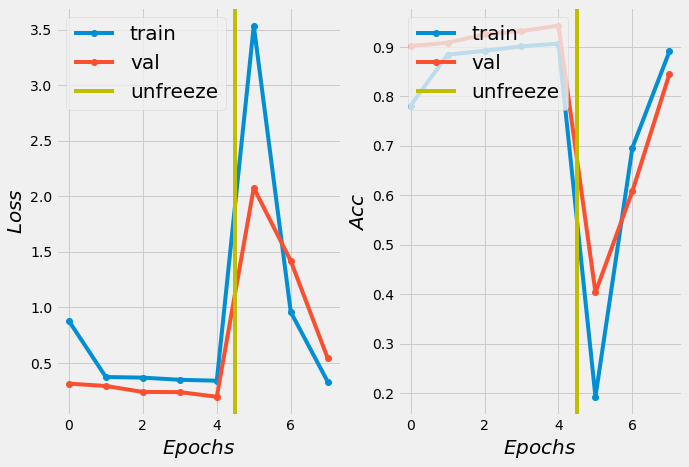

In [ ]:
visualize_cost(loss_cache_train, acc_cache_train, loss_cache_val, acc_cache_val)

In [ ]:
dir = '/content/Fruit-Images-Dataset/Test'
test_csv = '/content/drive/MyDrive/fruit_test.csv'
test_dataset = FruitsDataset(csv_file=test_csv, root_dir=dir, transform=test_trans)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
targets, preds = get_predictions(test_loader, model)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


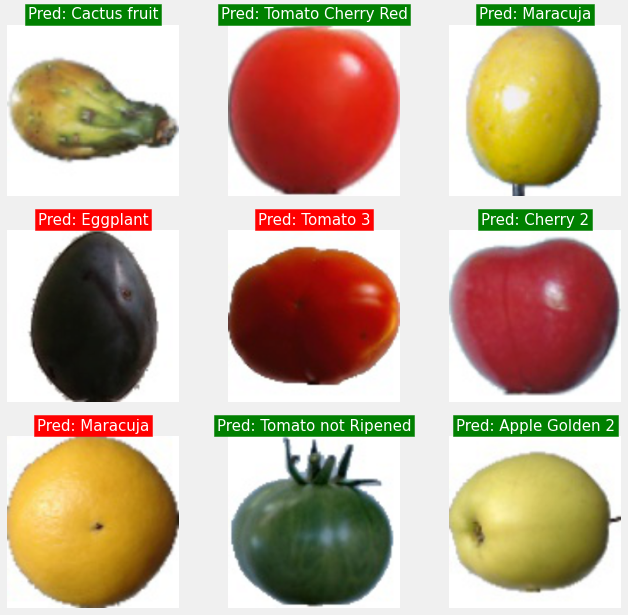

In [ ]:
visualize_model(fruit_names, 3, 3, test_dataset, mean, std, preds)

In [ ]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89       222
         1.0       0.79      0.99      0.88       160
         2.0       0.53      0.92      0.67       150
         3.0       1.00      0.39      0.57       157
         4.0       0.00      0.00      0.00       164
         5.0       0.74      0.98      0.84       164
         6.0       0.93      0.82      0.87       157
         7.0       0.74      1.00      0.85       158
         8.0       0.28      1.00      0.44       164
         9.0       0.89      0.90      0.89       166
        10.0       0.31      1.00      0.47       162
        11.0       0.67      0.05      0.09       164
        12.0       1.00      0.11      0.20       166
        13.0       0.87      0.59      0.70       164
        14.0       0.56      1.00      0.71       148
        15.0       1.00      0.87      0.93       153
        16.0       0.66      1.00      0.79       143
        17.0       0.97    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(confusion_matrix(targets, preds))

[[192   0   0 ...   0   0   0]
 [  0 159   0 ...   0   0   0]
 [  0   0 138 ...   0   0   0]
 ...
 [  0   0   2 ...   0   0   0]
 [  0   0   3 ...   0  54   0]
 [  0   0   0 ...   0   0 166]]


In [ ]:
check_accuracy(test_loader, test_dataset, model, fruit_names)

Test Acc


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Got 13980/22688 correct samples over 61.62%
Accuracy of Pepper Yellow: 86.49%
Accuracy of Orange: 99.38%
Accuracy of Onion Red: 92.00%
Accuracy of Watermelon: 39.49%
Accuracy of Peach Flat: 0.00%
Accuracy of Redcurrant: 97.56%
Accuracy of Kohlrabi: 82.17%
Accuracy of Grape White 4: 100.00%
Accuracy of Cherry 1: 100.00%
Accuracy of Cocos: 89.76%
Accuracy of Salak: 100.00%
Accuracy of Peach: 4.88%
Accuracy of Pineapple: 10.84%
Accuracy of Apple Granny Smith: 58.54%
Accuracy of Pepper Green: 100.00%
Accuracy of Pomelo Sweetie: 86.93%
Accuracy of Avocado: 100.00%
Accuracy of Tamarillo: 84.34%
Accuracy of Corn: 72.67%
Accuracy of Potato White: 56.00%
Accuracy of Kaki: 19.88%
Accuracy of Strawberry: 97.56%
Accuracy of Mandarine: 7.23%
Accuracy of Huckleberry: 99.40%
Accuracy of Limes: 100.00%
Accuracy of Passion Fruit: 0.00%
Accuracy of Rambutan: 100.00%
Accuracy of Pepper Red: 96.40%
Accuracy of Grapefruit White: 27.44%
Accuracy of Tomato Heart: 39.91%
Accuracy of Apple Golden 3: 0.00%
Accu

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


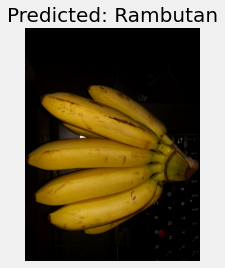

In [ ]:
path = '/content/Fruit-Images-Dataset/test-multiple_fruits/Bananas(lady_finger)1.jpg'
predict_single(model, path)

## Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/training_fruits/training'

In [ ]:
!tensorboard dev upload \
--logdir  '/content/drive/MyDrive/training_fruits/training' \
--name 'fruits_train' \
--description 'training on fruits dataset for 5 epochs fixed' \
--one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/XRcZXwJJTa6KJUPCpAv3Ig/

[2022-06-09T05:16:18] Started scanning logdir.
[2022-06-09T05:16:18] Total uploaded: 20 scalars, 0 tensors, 0 binary objects
[2022-06-09T05:16:18] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/XRcZXwJJTa6KJUPCpAv3Ig/


In [ ]:
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=88SDmdyryeqV7QG4O2VuIFtTR634dP&prompt=consent&access_type=offline
Enter the authorization c

In [ ]:
!tensorboard dev delete --experiment_id Zk2XDVvQQeSkNdjkj6LRKg
!tensorboard dev delete --experiment_id ngQAreS6TjWXiAt3f3mJkQ
!tensorboard dev delete --experiment_id 1UbeYV3LRpO9QzoBxZjSLw

Deleted experiment Zk2XDVvQQeSkNdjkj6LRKg.
Deleted experiment ngQAreS6TjWXiAt3f3mJkQ.
Deleted experiment 1UbeYV3LRpO9QzoBxZjSLw.


## Experiment

In [ ]:
load_model = True
load_model_file = '/content/drive/MyDrive/saved_ckpt/ckpt_epch5_acc0.94322.pth'
if load_model:
  loaded = torch.load(load_model_file)
  loss_cache_train = loaded['loss']
  acc_cache_train = loaded['acc']
  loss_cache_val = loaded['loss_val']
  acc_cache_val = loaded['acc_val']

In [ ]:
loss_cache_train

[0.877301440883202,
 0.37270094803734927,
 0.3671855203544451,
 0.34776942291795937,
 0.3394633908439242]

In [ ]:
a = np.concatenate((np.array(loss_cache_train), np.array(extrloss)), axis=None)
b = np.concatenate((np.array(acc_cache_train), np.array(extracc)), axis=None)
c = np.concatenate((np.array(loss_cache_val), np.array(exvaloss)), axis=None)
d = np.concatenate((np.array(acc_cache_val), np.array(exvaacc)), axis=None)

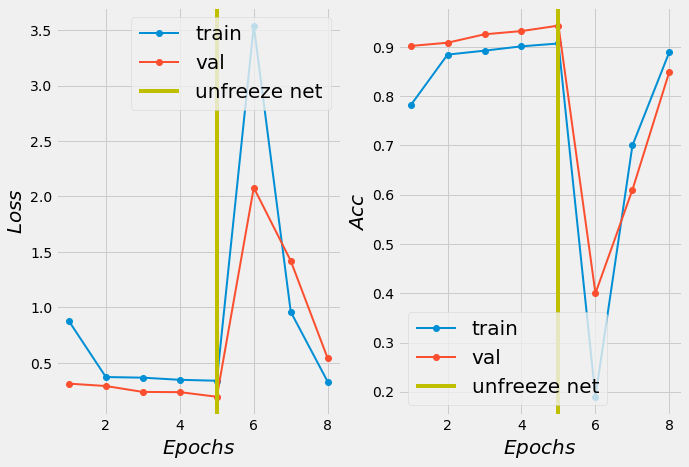

In [ ]:
# resumed training with connecting epochs
num_epochs=8
visualize_cost2(a,b,c,d, num_epochs)

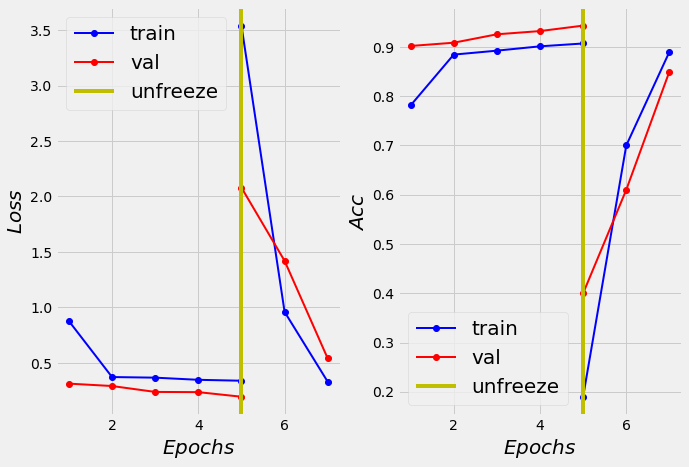

In [ ]:
# resumed training with disconnected epoch
num_epochs=7
visualize_cost(loss_cache_train, acc_cache_train, loss_cache_val, acc_cache_val, num_epochs, extrloss, extracc, exvaloss, exvaacc)

In [ ]:
writer_train = SummaryWriter(f'/content/drive/MyDrive/training_fruits/training/train')
writer_val = SummaryWriter(f'/content/drive/MyDrive/training_fruits/training/val')

In [ ]:
acc_cache_tr = [value.cpu().item() for value in acc_cache_train]
acc_cache_va = [value.cpu().item() for value in acc_cache_val]

In [ ]:
step=0
for i in range(3):
  writer_train.add_scalar('Loss', loss_cache_train[i], global_step=step)
  writer_train.add_scalar('Acc', acc_cache_tr[i], global_step=step)
  writer_val.add_scalar('Loss', loss_cache_val[i], global_step=step)
  writer_val.add_scalar('Acc', acc_cache_va[i], global_step=step)
  step+=1

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/training_fruits/training/train'

In [ ]:
!tensorboard dev upload \
--logdir  '/content/drive/MyDrive/training_fruits/training' \
--name 'experiment' \
--description 'training fruits dataset' \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/drive/MyDrive/training_fruits/training

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=m7g4us7CWDCiTGEDTsEzp4VZBgcg6v&